In [86]:
import glob
from pathlib import Path

import contextily as ctx
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, shape, box

from tqdm import tqdm

In [2]:
! ls ../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF | head


CSES_01_EFD_1_L02_A1_027321_20180731_233412_20180801_001019_000.csv
CSES_01_EFD_1_L02_A1_027330_20180801_001744_20180801_005841_000.csv
CSES_01_EFD_1_L02_A1_027331_20180801_010513_20180801_014503_000.csv
CSES_01_EFD_1_L02_A1_027340_20180801_015228_20180801_022940_000.csv
CSES_01_EFD_1_L02_A1_027341_20180801_023956_20180801_031710_000.csv
CSES_01_EFD_1_L02_A1_027350_20180801_032712_20180801_040447_000.csv
CSES_01_EFD_1_L02_A1_027351_20180801_041440_20180801_045154_000.csv
CSES_01_EFD_1_L02_A1_027360_20180801_050156_20180801_054218_000.csv
CSES_01_EFD_1_L02_A1_027360_20180801_051057_20180801_051057_000.csv
CSES_01_EFD_1_L02_A1_027361_20180801_054924_20180801_062638_000.csv
ls: write error: Broken pipe


In [3]:
df = pd.read_csv(
    "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027321_20180731_233412_20180801_001019_000.csv"
)

In [4]:
df

,Lon,Lat,UTCTime
0,57.577400,-69.603220,2018-07-31 23:34:14.620
1,57.434550,-69.483170,2018-07-31 23:34:16.668
2,57.293198,-69.363045,2018-07-31 23:34:18.716
3,57.153310,-69.242800,2018-07-31 23:34:20.764
4,57.014862,-69.122460,2018-07-31 23:34:22.812
...,...,...,...
1060,8.973442,68.669900,2018-08-01 00:11:08.234
1061,8.839660,68.791140,2018-08-01 00:11:10.282
1062,8.704508,68.912254,2018-08-01 00:11:12.330
1063,8.567965,69.033295,2018-08-01 00:11:14.378


# Define lat lon parameters

In [344]:
MIN_LON, MAX_LON = -175, 180
MIN_LAT, MAX_LAT = -75, 75

LON_DIVISIONS = 18
LAT_DIVISIONS = 9

lon_step = (MAX_LON - MIN_LON) / LON_DIVISIONS
lat_step = (MAX_LAT - MIN_LAT) / LAT_DIVISIONS


def get_grid_position(lon, lat, MIN_LON, MIN_LAT, LON_DIVISIONS, LAT_DIVISIONS):
    lat_index = int((lat - MIN_LAT) / lat_step)
    lon_index = int((lon - MIN_LON) / lon_step)
    return lat_index, lon_index


df["grid_cell"] = df.apply(
    lambda row: get_grid_position(
        row["Lat"], row["Lon"], MIN_LON, MIN_LAT, lat_step, lon_step
    ),
    axis=1,
)

df[["lat_index", "lon_index"]] = pd.DataFrame(df["grid_cell"].tolist(), index=df.index)


df = df.drop(columns=["grid_cell"])

df

,Lon,Lat,UTCTime,lat_index,lon_index
0,-51.181640,-69.598370,2022-11-30 07:11:07.819,1,5
1,-51.327910,-69.478700,2022-11-30 07:11:09.867,1,5
2,-51.472538,-69.358900,2022-11-30 07:11:11.916,1,5
3,-51.615673,-69.239136,2022-11-30 07:11:13.962,1,5
4,-51.757410,-69.119090,2022-11-30 07:11:16.012,1,5
...,...,...,...,...,...
1066,-100.990920,68.785230,2022-11-30 07:48:13.742,-1,12
1067,-101.128510,68.905390,2022-11-30 07:48:15.791,-1,12
1068,-101.267494,69.025475,2022-11-30 07:48:17.838,-1,12
1069,-101.407936,69.145450,2022-11-30 07:48:19.887,-1,12


GRID LAT AND LON INDEX FOR 1 FILE

In [345]:
grid_counts = df.groupby(['lat_index', 'lon_index']).size().reset_index(name='counts')

table = grid_counts.pivot(columns='lat_index', index='lon_index', values='counts').fillna(0)

table

lat_index,-1,0,1
lon_index,,,
5,0.0,40.0,62.0
6,0.0,152.0,0.0
7,0.0,151.0,0.0
8,0.0,149.0,0.0
9,0.0,150.0,0.0
10,0.0,152.0,0.0
11,42.0,111.0,0.0
12,62.0,0.0,0.0


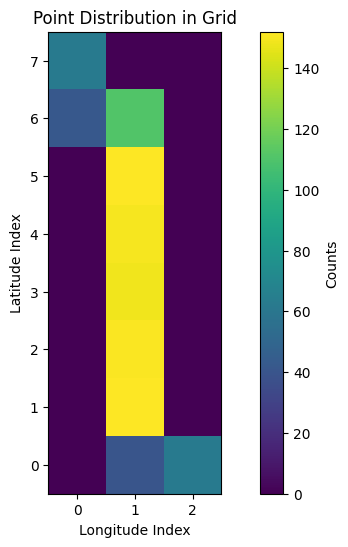

In [346]:
plt.figure(figsize=(10, 6))
plt.imshow(table, cmap='viridis', origin='lower')
plt.colorbar(label='Counts')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.title('Point Distribution in Grid')
plt.show()

DATAFRAME FOR ALL THE FILES

In [347]:
import glob

In [348]:
def process_file(
    path, min_lon, max_lon, min_lat, max_lat, lat_divisions, lon_divisions
):
    df = pd.read_csv(path)
    df = df.dropna()
    df = df[df.Lat.between(min_lat, max_lat) & df.Lon.between(min_lon, max_lon)]
    
    lon_step = (max_lon - min_lon) / lon_divisions
    lat_step = (max_lat - min_lat) / lat_divisions

    # def get_grid_position(lon, lat, min_lon, min_lat, lon_step, lat_step):
    #     lat_index = int((lat - min_lat) / lat_step)
    #     lon_index = int((lon - min_lon) / lon_step)
    #     return lat_index, lon_index

    df["lat_index"] = ((df.Lat - min_lat) / lat_step).astype(int)
    df["lon_index"] = ((df.Lon - min_lon) / lon_step).astype(int)

    return df


# file_paths = [
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027321_20180731_233412_20180801_001019_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027330_20180801_001744_20180801_005841_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027331_20180801_010513_20180801_014503_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027340_20180801_015228_20180801_022940_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027341_20180801_023956_20180801_031710_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027350_20180801_032712_20180801_040447_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027351_20180801_041440_20180801_045154_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027360_20180801_050156_20180801_054218_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027360_20180801_051057_20180801_051057_000.csv",
#     "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_027361_20180801_054924_20180801_062638_000.csv"
# ]

file_paths = glob.glob(
    "../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/*csv"
)
file_paths[:5], len(file_paths)

(['../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_244340_20220628_171631_20220628_175343_000.csv',
  '../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_194650_20210805_191751_20210805_195230_000.csv',
  '../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_265940_20221117_195050_20221117_202804_000.csv',
  '../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_179381_20210427_085830_20210427_093309_000.csv',
  '../../../grp2/scientific-dashboard/data/processed/metadata/EFD_ULF/CSES_01_EFD_1_L02_A1_223170_20220209_103657_20220209_104259_000.csv'],
 27274)

In [376]:
all_grid_dfs = []

for file_path in tqdm(file_paths):
    grid_df = process_file(
        file_path,
        min_lat=MIN_LAT,
        max_lat=MAX_LAT,
        min_lon=MIN_LON,
        max_lon=MAX_LON,
        lat_divisions=LAT_DIVISIONS,
        lon_divisions=LON_DIVISIONS,
    )
    all_grid_dfs.append(grid_df)

combined_grid_df = pd.concat(all_grid_dfs, ignore_index=True)

combined_grid_df

100%|██████████| 27274/27274 [00:55<00:00, 487.37it/s]


,Lon,Lat,UTCTime,lat_index,lon_index
0,-24.887533,69.509990,2022-06-28 17:16:31.847,8,7
1,-25.032930,69.389780,2022-06-28 17:16:33.894,8,7
2,-25.176764,69.269470,2022-06-28 17:16:35.943,8,7
3,-25.319046,69.149055,2022-06-28 17:16:37.990,8,7
4,-25.459995,69.028490,2022-06-28 17:16:40.038,8,7
...,...,...,...,...,...
23758037,-100.990920,68.785230,2022-11-30 07:48:13.742,8,3
23758038,-101.128510,68.905390,2022-11-30 07:48:15.791,8,3
23758039,-101.267494,69.025475,2022-11-30 07:48:17.838,8,3
23758040,-101.407936,69.145450,2022-11-30 07:48:19.887,8,3


## GRID LAT AND LON INDEX FOR ALL THE FILES

In [371]:
grid_counts = (
    combined_grid_df.groupby(["lat_index", "lon_index"])
    .size()
    .reset_index(name="counts")
)

table_complete = grid_counts.pivot(
    columns="lat_index", index="lon_index", values="counts"
).fillna(0)

table_complete

lat_index,0,1,2,3,4,5,6,7,8
lon_index,,,,,,,,,
0,87754.0,156301.0,152117.0,145636.0,149807.0,150973.0,150722.0,151167.0,85840.0
1,84439.0,153164.0,150495.0,148687.0,149244.0,149754.0,149582.0,150030.0,84967.0
2,84304.0,149448.0,148123.0,150416.0,148883.0,151185.0,151991.0,157750.0,86879.0
3,85496.0,151649.0,151485.0,151555.0,150271.0,142713.0,149667.0,153451.0,85991.0
4,84695.0,149738.0,150664.0,151718.0,149501.0,146062.0,152003.0,155596.0,85494.0
5,85563.0,153127.0,149451.0,149100.0,147166.0,149839.0,149923.0,152501.0,86703.0
6,85309.0,159068.0,157198.0,153312.0,152698.0,150336.0,149627.0,149627.0,85846.0
7,84280.0,154627.0,155904.0,158075.0,168872.0,173121.0,174463.0,163139.0,88833.0
8,85582.0,155257.0,156058.0,158805.0,153340.0,156691.0,154731.0,165398.0,98032.0


DENSITY GRID (IMG) ALL THE FILES

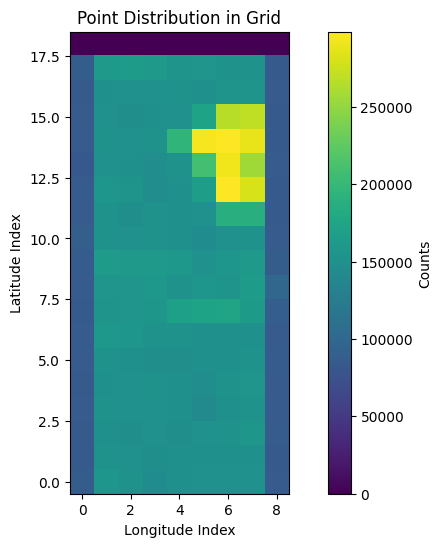

In [373]:
plt.figure(figsize=(10, 6))
plt.imshow(table_complete, cmap='viridis', origin='lower')
plt.colorbar(label='Counts')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.title('Point Distribution in Grid')
plt.show()

In [374]:
density_df = (
    combined_grid_df.groupby(["lat_index", "lon_index"])
    .size()
    .reset_index(name="density")
)
density_df


,lat_index,lon_index,density
0,0,0,87754
1,0,1,84439
2,0,2,84304
3,0,3,85496
4,0,4,84695
...,...,...,...
158,8,13,85437
159,8,14,84913
160,8,15,85053
161,8,16,85838


[(-165.13888888888886, -66.66666666666666)]

Text(480.35466938689024, 0.5, 'Latitude')

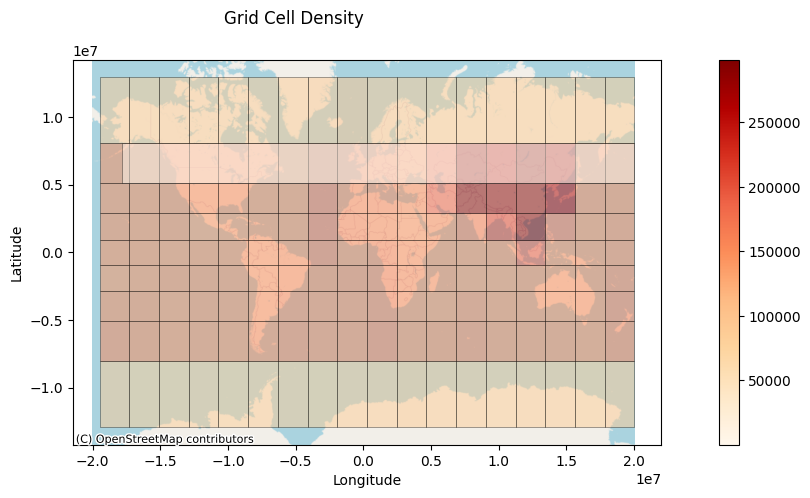

In [375]:
geometries = [
    box(
        MIN_LON + lon_index * lon_step,
        MIN_LAT + lat_index * lat_step,
        MIN_LON + (lon_index + 1) * lon_step,
        MIN_LAT + (lat_index + 1) * lat_step,
    )
    for lat_index, lon_index in zip(density_df["lat_index"], density_df["lon_index"])
]

gdf = gpd.GeoDataFrame(density_df, geometry=geometries, crs="EPSG:4326")

# Plot the grid cell densities on a map
fig, ax = plt.subplots(figsize=(15, 5))
gdf.to_crs(epsg=3857).plot(
    # gdf.plot(
    column="density",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.5,
)

ctx.add_basemap(
    ax,
    zoom=2,
    source=cx.providers.OpenStreetMap.Mapnik,
    # crs=gdf.crs,
)  # Use another provider
fig.suptitle("Grid Cell Density")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [231]:
len(geometries)

162

In [120]:
LAT_DIVISIONS

9

In [114]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat), crs="EPSG:4326")
gdf

,Lon,Lat,UTCTime,lat_index,lon_index,geometry
0,57.577400,-69.603220,2018-07-31 23:34:14.620,1,11,POINT (57.5774 -69.60322)
1,57.434550,-69.483170,2018-07-31 23:34:16.668,1,11,POINT (57.43455 -69.48317)
2,57.293198,-69.363045,2018-07-31 23:34:18.716,1,11,POINT (57.2932 -69.36304)
3,57.153310,-69.242800,2018-07-31 23:34:20.764,1,11,POINT (57.15331 -69.2428)
4,57.014862,-69.122460,2018-07-31 23:34:22.812,1,11,POINT (57.01486 -69.12246)
...,...,...,...,...,...,...
1060,8.973442,68.669900,2018-08-01 00:11:08.234,7,9,POINT (8.97344 68.6699)
1061,8.839660,68.791140,2018-08-01 00:11:10.282,7,9,POINT (8.83966 68.79114)
1062,8.704508,68.912254,2018-08-01 00:11:12.330,7,9,POINT (8.70451 68.91225)
1063,8.567965,69.033295,2018-08-01 00:11:14.378,7,9,POINT (8.56796 69.0333)


<Axes: >

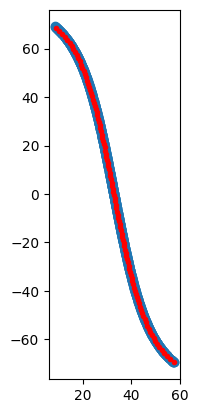

In [117]:
ax = gdf.plot()
gdf.iloc[::10].plot(ax=ax, color="red", marker=".",)


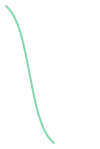

In [116]:
# convert a list of points to a LineString
LineString(gdf.geometry)

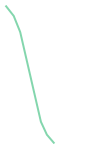

In [145]:
ls = LineString(gdf.geometry)
ls.simplify(1)

# Merge all files of a payload

In [146]:
from parsing import parse_filename
from tqdm import tqdm

In [147]:
# def get_semiorbit_id(fname):
#     if "EFD" in fname:
#         return Path(fname).stem.split("_")[6]
#     raise ValueError("Not an supported payload")

In [148]:
base_folder = Path("../data/processed/metadata/")

In [149]:
payload = "EFD_ULF"

In [150]:
payload_files = sorted(glob.glob(str(base_folder / payload / "*.csv")))
len(payload_files), payload_files[:5]

(0, [])

In [155]:
payload_metadata = []

for file in tqdm(payload_files):
    fn_data = parse_filename(Path(file).stem)
    df = pd.read_csv(file)

    df = df.dropna(subset=["Lat", "Lon"])
    if df.empty:
        continue

    # df = pd.read_csv(file, parse_dates=["UTCTime"])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat), crs="EPSG:4326")

    # gdf["semiorbit_nr"] = fn_data["semiorbit_nr"]
    # gdf = gdf.drop(columns=["Lat", "Lon"])

    ls = LineString(gdf.geometry)
    ls = ls.simplify(.1)
    d = {
        "semiorbit_nr": fn_data["semiorbit_nr"],
        "geometry": ls,
        "start_time": gdf.UTCTime.min(),
        "end_time": gdf.UTCTime.max(),
    }

    payload_metadata += [d]

# payload_metadata = pd.concat(payload_metadata)
payload_metadata = gpd.GeoDataFrame(payload_metadata)
payload_metadata

0it [00:00, ?it/s]


""


In [130]:
# fig, ax = plt.subplots(figsize=(10, 10))

# payload_metadata.iloc[:10000].to_crs("epsg:3857").plot(alpha=0.1 ,marker=".", ax=ax)
# cx.add_basemap(ax)

In [158]:
payload_metadata

""


TypeError: no numeric data to plot

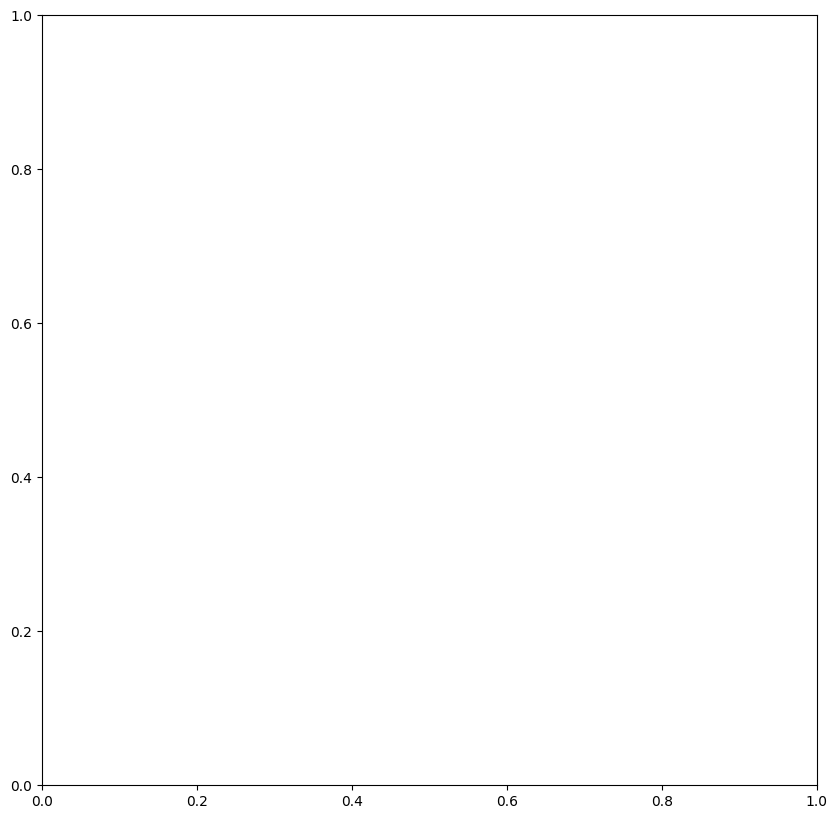

In [160]:
fig, ax = plt.subplots(figsize=(10, 10))

# payload_metadata.iloc[:2].set_crs("epsg:4326").to_crs("epsg:3857").plot(alpha=1, ax=ax)
payload_metadata.iloc[:2].plot(alpha=1, ax=ax)
cx.add_basemap(ax)


In [133]:
version = "v3"
payload_metadata.iloc[:].to_file(f"./data/processed/{payload}_metadata_{version}.gpkg")

ValueError: You must provide at least a geometry column or a field

In [ ]:
payload_metadata